In [1]:
import pandas as pd
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
# 读取Excel文件到DataFrame中
df = pd.read_csv('/root/2023mcm/Problem_C_Data_Wordle(1).csv', header=0)

# 反向索引DataFrame
reversed_df = df.iloc[::-1]

# 打印反向排序后的DataFrame
df=reversed_df

In [2]:
# 将日期列转换为时间戳格式
df["Date"] = pd.to_datetime(df["Date"])
# 删除缺失值和重复值
df = df.dropna().drop_duplicates()

Number of outliers: 35


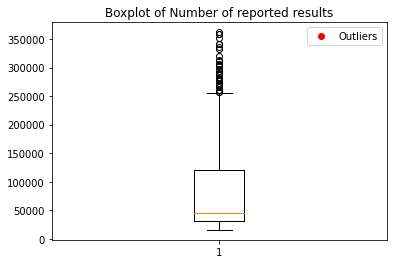

In [3]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# 提取目标值和特征
target = df.iloc[:, 3]
# 绘制箱线图
fig, ax = plt.subplots()
ax.boxplot(target)
ax.set_title('Boxplot of Number of reported results')

# 计算极端值线
q1 = target.quantile(0.25)
q3 = target.quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# 标记异常值
outliers = df.loc[(target < lower_bound) | (target > upper_bound)]
print(f"Number of outliers: {len(outliers)}")
ax.plot([], [], 'o', label='Outliers', color='red')
ax.legend()


In [4]:
target[31],target[32]

(23739, 26051)

In [5]:
target=target.values.reshape(-1,1).copy()
# 数据归一化
scaler = MinMaxScaler()
target_norm = scaler.fit_transform(target)


# 将数据转换为PyTorch张量
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
target_tensor = torch.from_numpy(target_norm).float().to(device)

# 构建LSTM模型
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_rate=0.2):
        super(MLP, self).__init__()
        self.hidden_size = hidden_size
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out


# 定义模型超参数
input_size = 1
hidden_size = 72
output_size = 1
seq_length = 14

# 初始化模型
model = MLP(input_size, hidden_size, output_size).to(device)

# 定义优化器和损失函数
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 划分训练集、验证集和测试集
train_data = target_tensor[:-60]
valid_data = target_tensor[-60:-30]
test_data = target_tensor[-30:]

# 训练模型
num_epochs = 2000
train_losses = []
valid_losses = []
for epoch in range(num_epochs):
    for i in range(seq_length, train_data.shape[0]):
        optimizer.zero_grad()
        inputs = train_data[i - seq_length:i].view(1, seq_length, 1)
        targets = train_data[i].view(1, 1)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
    train_losses.append(loss.item())
    
    # 验证模型
    with torch.no_grad():
        valid_preds = []
        for i in range(seq_length, valid_data.shape[0]):
            inputs = valid_data[i - seq_length:i].view(1, seq_length, 1)
            targets = valid_data[i].view(1, 1)
            outputs = model(inputs)
            valid_preds.append(outputs.item())
        valid_preds = np.array(valid_preds)
        valid_loss = criterion(torch.from_numpy(valid_preds).float().to(device), valid_data[-len(valid_preds):])
        valid_losses.append(valid_loss.item())

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Train Loss {loss.item()}, Valid Loss {valid_loss.item()}")

# 绘制训练和验证集上的损失曲线
plt.plot(train_losses, label="Train")
plt.plot(valid_losses, label="Valid")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

/root/miniconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1, 14, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


ValueError: only one element tensors can be converted to Python scalars

In [ ]:
test_data.size()
print(model)

In [ ]:
# 测试模型
model.eval()
predictions = []
for i in range(seq_length, test_data.shape[0]):
    inputs = test_data[i - seq_length:i].view(1, seq_length, 1)
    with torch.no_grad():
        outputs = model(inputs)
    predictions.append(outputs.item())
predictions = np.array(predictions)

# 反归一化
predictions_norm = scaler.inverse_transform(predictions.reshape(-1,1))
test_data_norm = scaler.inverse_transform(test_data[-len(predictions):].cpu().detach().numpy())

# 绘制模型在测试集上的表现
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(df["Date"][-len(test_data_norm):], test_data_norm.flatten(), label="True", color='red')
ax.plot(df["Date"][-len(predictions_norm):], predictions_norm, label="Predicted", color='blue')
ax.set_xlabel("Date")
ax.set_ylabel("Number of Reported Results")
ax.legend()

# 绘制测试集上的损失曲线
test_loss = criterion(torch.from_numpy(predictions).float().to(device), test_data[-len(predictions):])
print(f"Test Loss: {test_loss.item():.4f}")
plt.figure(figsize=(10, 5))
plt.plot(test_data_norm.flatten(), label="True", color='red')
plt.plot(predictions_norm, label="Predicted", color='blue')
plt.legend()
plt.title(f"Test Loss: {test_loss.item():.4f}")
plt.xlabel("Time (days)")
plt.ylabel("Number of Reported Results")
plt.show()

In [ ]:
np.shape(predictions_norm),np.shape(test_data_norm)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(test_data_norm, predictions_norm)
mae = mean_absolute_error(test_data_norm, predictions_norm)

print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")


In [ ]:
# 构造2022-3-1的输入序列
inputs = torch.from_numpy(test_data[-seq_length:].cpu().detach().numpy()).float().to(device)
predictions = []

# 预测未来14天的结果
for i in range(14):
    with torch.no_grad():
        outputs = model(inputs.view(1, seq_length, 1))
        predictions.append(outputs.item())
        inputs = torch.cat((inputs[1:], outputs), axis=0)

# 反归一化
predictions_norm = scaler.inverse_transform(np.array(predictions).reshape(-1,1))

# 打印预测结果
print(f"2022-3-1的预测结果区间为：[{predictions_norm.min():.0f}, {predictions_norm.max():.0f}]")


In [ ]:
test_data[-seq_length:]